# Reinforcement Learning in action

## Introduction

Todo: building photo with PV, battery and grid
Basic introduction to the problem

This tutorial is based on the simulation engine [Pymgrid](https://github.com/Total-RD/pymgrid) by Total-RD

## Install and imports

In [1]:
# first we will download the (custom) pymgrid library
# !pip install git+https://github.com/Wenuka/pymgrid/

In [2]:
import sys
from pymgrid import MicrogridGenerator as mg
import matplotlib.pyplot as plt
import numpy as np
import os
import time

from helper_functions import *

## Generate Microgrids
a.k.a Building with a Solar panel (PV), inhouse battery pack which is also connected to the grid

In [3]:
# First we create the environment and the microgrid
env = mg.MicrogridGenerator(nb_microgrid=1, path="./data/pymgrid_data")  # we can use a custom file to simulate the load and the PV
env.generate_microgrid(verbose=False)
mg0 = env.microgrids[0]

In [4]:
mg0.architecture  # architecture of the microgrid 
# note that in this tutorial, we do not consider the situation with a generator (genset)

{'PV': 1, 'battery': 1, 'genset': 0, 'grid': 1}

In [5]:
mg0.parameters  # parameters of the microgrid 
# TODO: is this important?

,load,cost_loss_load,cost_overgeneration,cost_co2,PV_rated_power,battery_soc_0,battery_power_charge,battery_power_discharge,battery_capacity,battery_efficiency,battery_soc_min,battery_soc_max,battery_cost_cycle,grid_weak,grid_power_import,grid_power_export
0,96,10,1,0.1,76.8,0.2,61,61,242,0.9,0.2,1,0.02,0,192,192


In [21]:
print("Penetration PV Microgrid 1 :", round(mg0.parameters["PV_rated_power"][0]/mg0.parameters["load"][0]*100,2), "%")
# TODO: is this important?

Penetration PV Microgrid 1 : 80.0 %


## Defining the State 


As we already learned, the Q table has the maximum expected future reward that the agent will get if it takes that action at that state. Therefore it is nothing but an table with States as rows and Actions as columns.

<img src="files/data/qtable.png" width=350>

So, before starting the learning process, we should concretely define the states and the actions. 

First, we will start with defining the state. To help the process, we will first plot few graphs for the next 24 time steps (hours).

(extra note: forecast function forcast next 24 steps by default you can change it to N steps by **mg0.set_horizon(N)** )

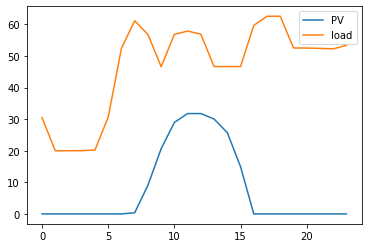

In [8]:
plt.plot(mg0.forecast_pv(), label="PV")
plt.plot(mg0.forecast_load(), label="load")
plt.legend()
# as we can see PV and Load is varying with the  time

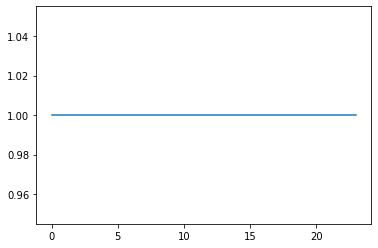

In [6]:
plt.plot(mg0.forecast_grid_status())  
# Here we observe that the microgrid is always connected to the utility grid (no change)

As we know, environment in this is defined by four factors, namely,
* Load (kW)
* PV (kW)
* Battery (cahrge percentage)
* Grid connectivity

<img src="files/data/environment.png" width=400>

So, we can simple define state by **(load, PV, Battery %, Grid connectivity)**

But do we need all these variables to define the state? What variables/factors you can eliminate? Given our problem statement, what variables you can combine?

**Discuss!**

Answer:
* We can remove grid connectivity in here as it is always 1
* We can combne Load and PV as it is always the Net_load (load-PV) is needed to be considered.

Therefore the state can be defined as ( Net_load, battery %)

Extra Note: we can also define the state as (load, PV, battery %) and continue. Then the only problem will be the inefficient learning due to the (relatively) un-necessarily bigger state space.

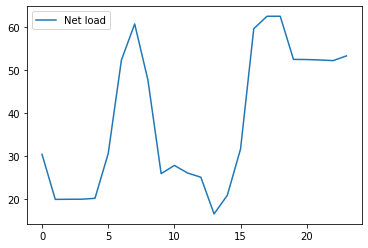

In [9]:
plt.plot(mg0.forecast_load()-mg0.forecast_pv(), label="Net load")
plt.legend()

Another problem we face here is how to create Q-table when the variables in the state definition are continuous. 

For this, we **discretize the variable**. For example in this tutorial, we round the kW to the nearest deciamal and battery percentage to the nearest 0.1

In [22]:
# For a given instences, you can see the environment values like this
current_load = mg0.load
current_pv = mg0.pv
battery_capacity = mg0.battery.capacity

## Designing the Actions

Since we now have defined the states, let's try to define the different possible actions that our agent will have to take in the microgrid environment. 

These are the four actions that we are suggesting
* action 0: battery_charge
* action 1: battery_discharge
* action 2: grid_import
* action 3: grid_export



However, our simulation engine does not know what are this actions are.

For this, we have to map these actions to the simulation engines control signals

In [12]:
def actions_agent(mg0, action):
    pv = mg0.pv
    load = mg0.load
    net_load = load - pv
    capa_to_charge = mg0.battery.capa_to_charge  # remaining capacity to charge of the battery
    p_charge_max = mg0.battery.p_charge_max  # charge speed of the battery
    p_charge = max(0,min(-net_load, capa_to_charge, p_charge_max))  # charge value for the time 
    
    capa_to_discharge = mg0.battery.capa_to_discharge  # capacity of discharge
    p_discharge_max = mg0.battery.p_discharge_max  # per hour discharge rate
    p_discharge = max(0,min(net_load, capa_to_discharge, p_discharge_max))  # discharge value for the time 
          
    if action == 0:       
        if p_charge > 0:  # if charge is possible
            control_dict = {'pv_consummed': min(pv,load),
                            'battery_charge': p_charge,
                            'battery_discharge': 0,
                            'grid_import': 0,
                            'grid_export':max(0,pv - min(pv,load) - p_charge)
                           }
        else:  # if either battery is full or R<D (p_charge==0 coz it cant be -) => why this else?? todo
            control_dict = {'pv_consummed': min(pv,load),
                            'battery_charge': net_load,  # possible - charge ??
                            'battery_discharge': 0,
                            'grid_import': 0,
                            'grid_export':max(0,pv - min(pv,load) - p_charge)
                           }            
    elif action ==1:    
        if p_discharge > 0:
            control_dict = {'pv_consummed': min(pv,load),
                            'battery_charge': 0,
                            'battery_discharge': p_discharge,
                            'grid_import': max(0,load - min(pv,load) - p_discharge),
                            'grid_export':0
                           }
        else:
            control_dict = {'pv_consummed': min(pv,load),
                            'battery_charge': 0,
                            'battery_discharge': net_load,
                            'grid_import': max(0,load - min(pv,load) - p_discharge),
                            'grid_export':0
                           }
    elif action ==2:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': 0,
                        'grid_import': abs(net_load),
                        'grid_export':0
                       }
    elif action == 3:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': 0,
                        'grid_import': 0,
                        'grid_export':abs(net_load)
                       }
    
    return control_dict

## Initializing the Q table

In [23]:
def init_qtable(mg0, nb_action):
    mg0.set_horizon(24*365)  # to forcast to have correct max and min, we look at the full range
    net_load = mg0.forecast_load() - mg0.forecast_pv()
    mg0.set_horizon(24)

    state = []
    Q = {}

    for i in range(int(net_load.min()-1),int(net_load.max())):
        
        for j in np.arange(round(mg0.battery.soc_min,1),round(mg0.battery.soc_max+0.1,1),0.1):
            
            j = round(j,1)
            state.append((i,j)) 
    
    #Initialize Q(s,a) at zero
    for s in state:

        Q[s] = {}

        for a in range(nb_action):

            Q[s][a] = 0
    return Q

If interested, please take a look in to the helper_functions.py as well. There, we have defined the exploration strategy where we have selected the **epsilon greedy decreasing strategy**.

## SARSA algorithm

In [14]:
def training_Q_Learning(mg,horizon):
    
    nb_action = 4
    Q = init_qtable(mg,nb_action)  # initialise Q-table
    nb_state = len(Q)
    nb_episode = 100
    alpha = 0.1
    epsilon = 0.99
    gamma = 0.99
    
    record_cost = []
    t0 = time.time()
    t = t0
    print_training = "Training Progressing .   "
    print_welcome(0)
    print("\n")
    for e in range(nb_episode+1):
        
        # print status
        if e == 0:
            value_print="\rEpisode " + str(e) +"/" + str(nb_episode)
            sys.stdout.write(value_print)
            sys.stdout.flush()
        else:
            now = time.time()
            if e == 1 or e == 50 or e == 100 or e == 200 or e == 300 or e == 400  or e == 450  or e == 485 or e == nb_episode-5:
                diff_time_t = now - t 
                total_time = (nb_episode+1) * diff_time_t
            now = time.time()
            diff_time = now - t0
            time_remaining = total_time - diff_time
            t = time.time()
        
        if e % 10 == 0:
            if print_training == "Training Progressing .   ":
                print_training = "Training Progressing ..  "
            elif print_training == "Training Progressing ..  ":
                print_training = "Training Progressing ... "
            else:
                print_training = "Training Progressing .   "

        value_print="\r"+ print_training +"Episode " + str(e) +"/" + str(nb_episode) 
        sys.stdout.write(value_print)
        sys.stdout.flush()
        
        # learning algo start
        episode_cost = 0
        mg.reset()
        
        net_load = round(mg.load - mg.pv)
        soc = round(mg.battery.soc,1)
        s = (net_load, soc)
        
        a = max_dict(Q[s])[0]  # action with max val 
        a,randomm = espilon_decreasing_greedy(a, epsilon, nb_action)  # action after epsilon greedy
        
        for i in range (horizon):
            
            action = actions_agent(mg,a)  # returns control_dict for the action
            status = mg.run(action)
            r = -mg.get_cost() 
            episode_cost += mg.get_cost()
            net_load = round(mg.load - mg.pv)
            soc = round(mg.battery.soc,1)
            s_ = (net_load, soc)
            a_ = max_dict(Q[s_])[0]
            
            if i == horizon-1:
                Q[s][a] += alpha*(r - Q[s][a])
      
            else:
                old_Q = Q[s][a]
                target = r + gamma*Q[s_][a_]
                td_error = target - Q[s][a]
                Q[s][a] = (1-alpha) * Q[s][a] + alpha * target
                
            s, a = s_, a_
       
        epsilon = update_epsilon(epsilon)  # decrease epsilon
        
    return Q

In [15]:
def testing_Q_Learning(mg, Q,horizon):
    
    mg.reset(testing=True)
    net_load = round(mg.load - mg.pv)
    soc = round(mg.battery.soc,1)
    s = (net_load, soc)
    a = max_dict(Q[s])[0]
    total_cost = 0
    print_welcome(1)
    for i in range (horizon):

        action_name = change_name_action(a)
        action = actions_agent(mg, a)
        status = mg.run(action)
        cost = mg.get_cost()
        total_cost += cost
        if i < 10:
            print(i," -",(int(net_load),soc),action_name, round(total_cost,1), "€")
        else:
            print(i,"-",(int(net_load),soc),action_name, round(total_cost,1), "€")
        net_load = round(mg.load - mg.pv)
        soc = round(mg.battery.soc,1)
        s_ = (net_load, soc)
        a_ = max_dict(Q[s_])[0]

        s, a = s_, a_

In [16]:
mg0.train_test_split(train_size=0.8)

In [17]:
Q1 = training_Q_Learning(mg0,48)

------------------------------------
|        WELCOME TO PYMGRID        |
------------------------------------


Training Progressing ... Episode 100/100

In [18]:
testing_Q_Learning(mg0,Q1, 48)

t -     STATE  -  ACTION - COST
0  - (20, 0.2) import 4.9 €
1  - (20, 0.2) import 9.9 €
2  - (20, 0.2) import 15.0 €
3  - (21, 0.2) discharge 20.2 €
4  - (31, 0.2) discharge 28.1 €
5  - (53, 0.2) discharge 41.3 €
6  - (59, 0.2) charge 1230.1 €
7  - (46, 0.4) charge 2157.6 €
8  - (23, 0.6) discharge 2158.0 €
9  - (22, 0.5) discharge 2158.5 €
10 - (16, 0.4) charge 2485.5 €
11 - (16, 0.4) charge 2802.2 €
12 - (8, 0.5) charge 2953.6 €
13 - (9, 0.5) charge 3126.7 €
14 - (17, 0.6) discharge 3127.0 €
15 - (37, 0.5) charge 3876.5 €
16 - (49, 0.6) charge 4850.1 €
17 - (63, 0.8) discharge 4852.5 €
18 - (53, 0.5) import 4868.7 €
19 - (53, 0.5) import 4884.9 €
20 - (52, 0.5) discharge 4885.9 €
21 - (52, 0.3) import 4898.4 €
22 - (53, 0.3) import 4911.2 €
23 - (31, 0.3) import 4918.6 €
24 - (20, 0.3) import 4923.6 €
25 - (20, 0.3) import 4928.7 €
26 - (20, 0.3) import 4933.8 €
27 - (20, 0.3) import 4938.9 €
28 - (31, 0.3) import 4946.7 €
29 - (53, 0.3) import 4960.0 €
30 - (59, 0.3) charge 6148.8 €

## Q-Learning

What changes to do in the SARSA to make it Q-learning?

## Discussion

1. possible improvements
2. what could go wrong